In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import (GridSearchCV, learning_curve,
                                     train_test_split)
from transform_data import get_train_test_ds
from xgboost import XGBClassifier

random_state = 42

In [2]:
X, X_train, X_test, y, y_train, y_test = get_train_test_ds('income', 'data/adult.data', random_state)
# X, X_train, X_test, y, y_train, y_test = get_train_test_ds('bank', 'data/bank.csv', random_state)
X_train.shape, X_test.shape

((26048, 58), (6513, 58))

In [3]:
clf = XGBClassifier(n_estimators=500, random_state=random_state)
f1_scorer = make_scorer(f1_score)

In [4]:
param_grid = {'max_depth': [2, 3, 4, 5],
              'reg_alpha': [0, 0.01, 0.1, 1, 10],
              'reg_lambda': [0, 0.01, 0.1, 1, 10],
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring=f1_scorer)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

In [5]:
print("Best parameters:", grid_search.best_params_)

print("Train F1")
y_train_pred = best_model.predict(X_train)
train_f1_score = f1_score(y_train, y_train_pred)
print(train_f1_score)

print("Test F1")
y_test_pred = best_model.predict(X_test)
test_f1_score = f1_score(y_test, y_test_pred)
print(test_f1_score)

Best parameters: {'max_depth': 3, 'reg_alpha': 0.1, 'reg_lambda': 10}
Train F1
0.745364010989011
Test F1
0.7096107475025836


income
```
Best parameters: {'max_depth': 3, 'reg_alpha': 0.1, 'reg_lambda': 10}
Train F1
0.745364010989011
Test F1
0.7096107475025836
```

bank
```
Best parameters: {'max_depth': 3, 'reg_alpha': 1, 'reg_lambda': 0.1}
Train F1
0.6700929342890817
Test F1
0.6404170881643452
```

/home/jack/data/omscs/7641 - ml/venv/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


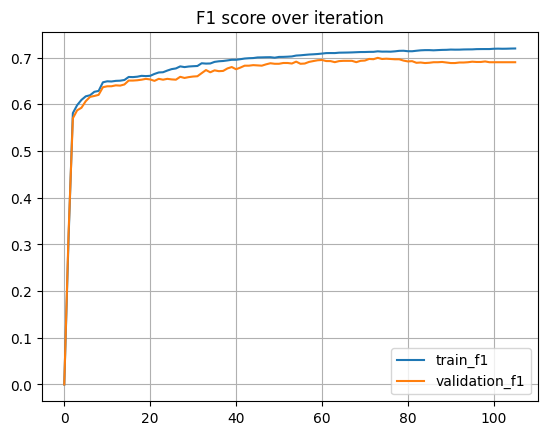

In [6]:
params = grid_search.best_params_.copy()

def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    return 'f1_err', 1-f1_score(y_true, np.round(y_pred))

clf = XGBClassifier(
    n_estimators=500, 
    random_state=random_state, 
    early_stopping_rounds=32,
    **params
)
X_train_inner, X_valid, y_train_inner, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=random_state, stratify=y_train)

eval_set = [(X_train_inner, y_train_inner), (X_valid, y_valid)]
clf.fit(X_train_inner, y_train_inner, eval_set=eval_set, eval_metric=f1_eval, verbose=False)

train_f1_err = [1-x for x in clf.evals_result()['validation_0']['f1_err']]
valid_f1_err = [1-x for x in clf.evals_result()['validation_1']['f1_err']]

plt.plot(train_f1_err, label='train_f1')
plt.plot(valid_f1_err, label='validation_f1')

plt.title(f"F1 score over iteration")
plt.legend()
plt.grid()
plt.show()

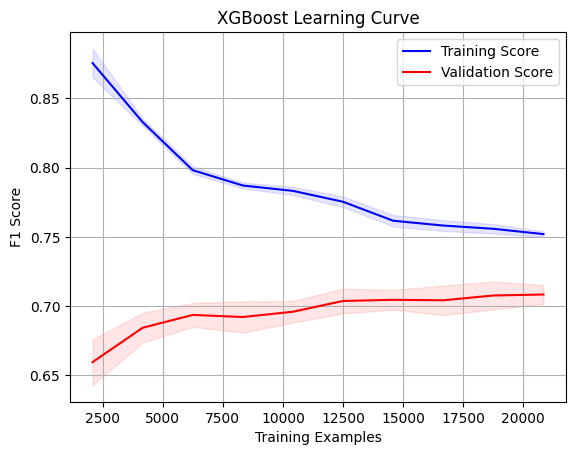

In [7]:
# Define the training sizes
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate learning curves
train_sizes_abs, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, train_sizes=train_sizes, cv=5, scoring=f1_scorer)

# Calculate the mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes_abs, train_scores_mean, label='Training Score', color='blue')
plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.plot(train_sizes_abs, val_scores_mean, label='Validation Score', color='red')
plt.fill_between(train_sizes_abs, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color='red')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.title('XGBoost Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

[0, 0.01, 0.1, 1, 10]


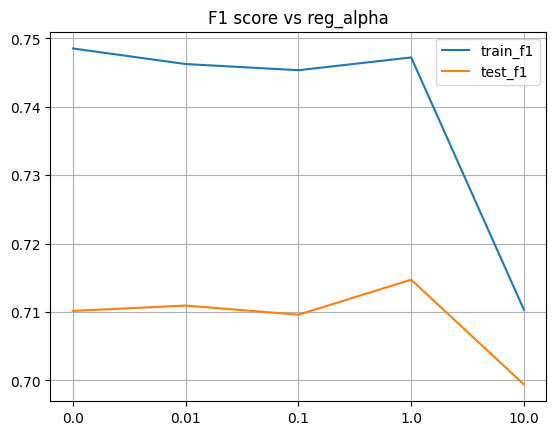

In [8]:
plot_param = 'reg_alpha'

param_list = param_grid[plot_param]
print(param_list)
train_f1_score_list = []
test_f1_score_list = []

for param in param_list:
    params = grid_search.best_params_.copy()
    params[plot_param] = param

    clf = XGBClassifier(n_estimators=500, random_state=random_state, **params)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    train_f1_score_list.append(f1_score(y_train, y_train_pred))

    y_test_pred = clf.predict(X_test)
    test_f1_score_list.append(f1_score(y_test, y_test_pred))

plot_df = pd.DataFrame({"train_f1": train_f1_score_list, "test_f1": test_f1_score_list}, index=param_list)
plot_df = plot_df.reset_index()

default_x_ticks = range(plot_df.shape[0])
plt.plot(default_x_ticks, plot_df['train_f1'], label='train_f1')
plt.plot(default_x_ticks, plot_df['test_f1'], label='test_f1')
plt.xticks(default_x_ticks, plot_df['index'])

plt.title(f"F1 score vs {plot_param}")
plt.legend()
plt.grid()
plt.show()

In [9]:
%%time

params = grid_search.best_params_.copy()
clf = XGBClassifier(n_estimators=500, random_state=random_state, **params)
clf.fit(X_train, y_train)

CPU times: user 7.89 s, sys: 19.5 ms, total: 7.91 s
Wall time: 705 ms


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [10]:
%%time

y_test_pred = clf.predict(X_test)

CPU times: user 78 ms, sys: 0 ns, total: 78 ms
Wall time: 12.2 ms
